## Notebook Imports

In [83]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Constants

In [84]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

# Reading Files

In [85]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [86]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [87]:
stream = open(EXAMPLE_FILE, encoding='utf-8')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)
#lines



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generater Functions

In [88]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [89]:
for i in generate_squares(5):
    print(i, end=' - ')

0 - 1 - 4 - 9 - 16 - 

## Email body extraction

In [90]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [91]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [92]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [93]:
spam_emails.shape

(1898, 2)

In [94]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,CATEGORY,MESSAGE
00769.25bf9a767b5db0ed93f03c1637281663,0,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ..."
01074.8590d61ac0aeeadb58dc2f2ba776c406,0,"Hiya, I always seem to get errors when I do an..."
02479.14365bcad3a60fcf24c5c1813f6291fb,0,\n\nI don't know how one can expect better and...
01417.ce7b07a2114218dbac682b599785820d,0,Tim Peters wrote:\n\n> I've run no experiments...
00357.d559b71616f64ba1d1c1e61a03644fd4,0,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr..."


In [95]:
ham_emails.shape

(3901, 2)

In [96]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [97]:
data.tail()

,CATEGORY,MESSAGE
00609.dd49926ce94a1ea328cce9b62825bc97,0,"I'm one of the 30,000 but it's not working ver..."
00957.e0b56b117f3ec5f85e432a9d2a47801f,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...
01127.841233b48eceb74a825417d8d918abf8,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\..."
01178.5c977dff972cd6eef64d4173b90307f0,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w..."
00747.352d424267d36975a7b40b85ffd0885e,0,"If you run Pick, and then use the ""New FTOC"" b..."


## Data Cleaning: Checking for missing values

In [98]:
# Check if any message bodies are null

data['MESSAGE'].isnull().values.any()

False

In [99]:
type("")
len("")

0

In [100]:
my_var = None
type(my_var)

NoneType

In [101]:
# Check if there are empty emails. (String length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [102]:
(data.MESSAGE.str.len() == 0).sum()

3

In [103]:
# Challange checking how many null values.

#(data.MESSAGE.str.len() == None).any()
data['MESSAGE'].isnull().sum()

0

## Locating empty emails

In [104]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [105]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [106]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove System File Entries from DataFrame

In [107]:
#data = data.drop(['cmds'])
#Same thing
#data.drop(['cmds'], inplace=True)

In [108]:
data.shape

(5799, 2)

In [109]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Add documetn IDs to Track emails in Dataset

In [110]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [111]:
data.DOC_ID

00249.5f45607c1bffe89f60ba1ec9f878039a       0
00373.ebe8670ac56b04125c25100a36ab0510       1
00214.1367039e50dc6b7adb0f2aa8aba83216       2
00210.050ffd105bd4e006771ee63cabc59978       3
00033.9babb58d9298daa2963d4f514193d7d6       4
                                          ... 
00609.dd49926ce94a1ea328cce9b62825bc97    5794
00957.e0b56b117f3ec5f85e432a9d2a47801f    5795
01127.841233b48eceb74a825417d8d918abf8    5796
01178.5c977dff972cd6eef64d4173b90307f0    5797
00747.352d424267d36975a7b40b85ffd0885e    5798
Name: DOC_ID, Length: 5799, dtype: int64

In [112]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [113]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5794,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5795,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5796,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5797,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0
5798,0,"If you run Pick, and then use the ""New FTOC"" b...",00747.352d424267d36975a7b40b85ffd0885e


## Save to File using Pandas

In [114]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised(Pie Charts)

In [115]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [116]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

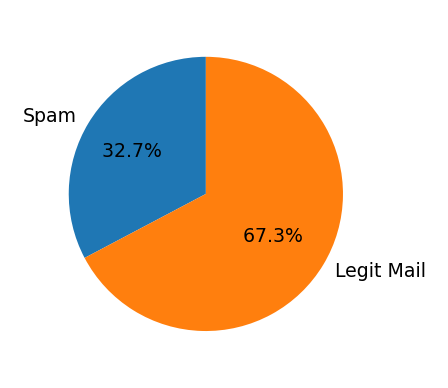

In [122]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%% ')
plt.show()

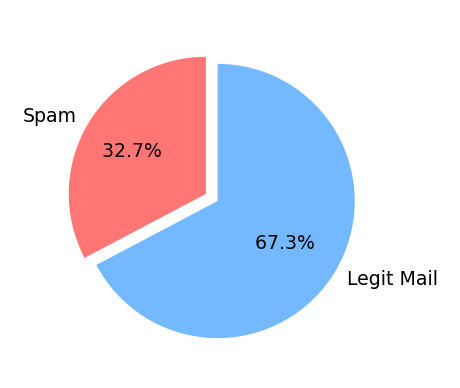

In [126]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%% ', colors=custom_colours, explode=[0, 0.1])
plt.show()